In [190]:
from mendeleev import element
#import pymatgen.core as mg
import matplotlib.pyplot as plt
#import matplotlib as mpl
#from mpl_toolkits.mplot3d import Axes3D
import numpy as np
#import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#import quadpy
from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations
from joblib import Parallel, delayed, parallel_backend
from scipy import integrate
import time
from datetime import timedelta
import plotly as plotly
import plotly.express as px
from plotly.offline import init_notebook_mode
#init_notebook_mode(connected=True)  
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.graph_objects as go
import latex
import os
from plotly.subplots import make_subplots
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
pio.renderers.default = "notebook_connected"

def crystal(i):
    switcher={
        45: "Li", 
        44: "Cu",
        43: "Mn",
        42: "Al",            
        41: "Au",            
        40: "Ca",      
        39: "Cr",        
        38: "Fe",            
        37: "Ge",            
        36: "Ir",      
        35: "Pd",        
        34: "Pt",            
        33: "Ru",            
        32: "Si",      
        31: "Tc",
        30: "Ti",
        29: "V",
        28: "W",
        27: "Mg",
        26: "Co",
        25: "Sc", 
        24: "Hg",
        23: "Mo", 
        22: "Os",
        21: "Rh",
        20: "Ag",
        19: "Cd",
        18: "Hf",
        17: "K",
        16: "Na",
        15: "Nb",
        14: "Ni",
        13: "Re",
        12: "Sb",
        11: "Sr",
        10: "Ta",
        9: "Y",
        8: "Zr",
        7: "Ba",
        6: "Cs",
        5: "In",
        4: "Rb",
        3: "Sn",
        2: "Pb",
        1: "Tl",
    }
    return switcher.get(i,"Invalid crystal")

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)  
import plotly.io as pio
pio.renderers.default = 'iframe'

df_OCTA=pd.read_csv("./OCTA_DATASET.csv")
df_TETRA=pd.read_csv("./TETRA_DATASET.csv")

# df_OCTA_BE=pd.read_csv("/home/massad/Documents/Linux_PHD/SUPERCELLS/BE/Binding_Energies_OI.csv")
# df_TETRA_BE=pd.read_csv("/home/massad/Documents/Linux_PHD/SUPERCELLS/BE/Binding_Energies_TI.csv")

# df_OCTA_SE=pd.read_csv("/home/massad/Documents/Linux_PHD/SUPERCELLS/BE/SolutionE_OI.csv")
# df_TETRA_SE=pd.read_csv("/home/massad/Documents/Linux_PHD/SUPERCELLS/BE/SolutionE_TI.csv")

frames = [df_OCTA, df_TETRA]

result = pd.concat(frames, keys=["OCTA", "TETRA"])
result = result.drop(columns = 'Name',axis=1)

# df_OCTA["VALENCE"]

In [191]:
def confidence_ellipse(x, y, n_std=1.96, size=100):
    """
    Get the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    size : int
        Number of points defining the ellipse
    Returns
    -------
    String containing an SVG path for the ellipse
    
    References (H/T)
    ----------------
    https://matplotlib.org/3.1.1/gallery/statistics/confidence_ellipse.html
    https://community.plotly.com/t/arc-shape-with-path/7205/5
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    theta = np.linspace(0, 2 * np.pi, size)
    ellipse_coords = np.column_stack([ell_radius_x * np.cos(theta), ell_radius_y * np.sin(theta)])
    
    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    x_scale = np.sqrt(cov[0, 0]) * n_std
    x_mean = np.mean(x)

    # calculating the stdandard deviation of y ...
    y_scale = np.sqrt(cov[1, 1]) * n_std
    y_mean = np.mean(y)
  
    translation_matrix = np.tile([x_mean, y_mean], (ellipse_coords.shape[0], 1))
    rotation_matrix = np.array([[np.cos(np.pi / 4), np.sin(np.pi / 4)],
                                [-np.sin(np.pi / 4), np.cos(np.pi / 4)]])
    scale_matrix = np.array([[x_scale, 0],
                            [0, y_scale]])
    ellipse_coords = ellipse_coords.dot(rotation_matrix).dot(scale_matrix) + translation_matrix
        
    path = f'M {ellipse_coords[0, 0]}, {ellipse_coords[0, 1]}'
    for k in range(1, len(ellipse_coords)):
        path += f'L{ellipse_coords[k, 0]}, {ellipse_coords[k, 1]}'
    path += ' Z'
    return path

In [192]:
# give to NaN some number which is always the same 
X_mdf=result

X_mdf['Ch(H) exchange']=X_mdf['Ch(H)']-1.00
X_mdf['Ch(M) exchange']=X_mdf['VALENCE']-X_mdf['Ch(M)']

# def diff(a, b):
#     return b - a

# X_mdf['Ch(H) exchange'] = X_mdf.apply(
#     lambda x: diff(x['Ch(H)'], 1.00), axis=1)

X_mdf=result.dropna(axis='columns')

#print("DISREGARDING\n",X_mdf.iloc[:, 6:27])
#X_mdf=X_mdf.drop(X_mdf.iloc[:, 4:5], axis = 1)
#X_mdf=X_mdf.drop(X_mdf.iloc[:, 6:27], axis = 1)

# del X_mdf["density"]
# del X_mdf["fusion_heat"]
# del X_mdf["glawe_number"]
# del X_mdf["mendeleev_number"]
# del X_mdf["boiling_point"]

# del X_mdf['covalent_radius_cordero']
# del X_mdf['covalent_radius_pyykko']
# del X_mdf['metallic_radius']
# del X_mdf['vdw_radius'] 
# del X_mdf['vdw_radius_alvarez']
# del X_mdf['vdw_radius_batsanov']
# del X_mdf['vdw_radius_uff']

print("DISREGARDING\n",X_mdf.iloc[:, 0:27])
X_mdf=X_mdf.drop(X_mdf.iloc[:, 0:27], axis = 1)
del X_mdf['BULKM'] 
del X_mdf['YOUNGM']
del X_mdf['SHEARM']
del X_mdf['POISSONR']
del X_mdf['Lat']
del X_mdf['Ch(H)']
del X_mdf['Ch(M)']
# X_mdf=X_mdf.drop(X_mdf.iloc[:, 0:16], axis = 1)
# X_mdf=X_mdf.drop(X_mdf.iloc[:, -5:], axis = 1)

# X_mdf.isna().sum()

def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

# result=swap_columns(X_mdf,'C(H) exchange','peak_width')
# result=swap_columns(X_mdf,'C(M) exchange','MAX_rdf')
# result=swap_columns(X_mdf,'V(M)','peak_width')
# result=swap_columns(X_mdf,'V(H)','MAX_rdf')

X_mdf=X_mdf[['VALENCE', 'Ch(M) exchange','Ch(H) exchange', 'Rad_M','Rad_H','V_M','V_H','peak_width','MAX_rdf']]

# TOREMOVE
# density                          0
# fusion_heat                      0
# glawe_number                     0
# mendeleev_number                 0
X_mdf

DISREGARDING
           Atomic Number  Atomic Radius  Atomic Volume  atomic_weight  \
OCTA  0              81          190.0          17.20     204.380000   
      1              82          180.0          18.30     207.200000   
      2              50          145.0          16.30     118.710000   
      3              37          235.0          55.90      85.467800   
      4              49          155.0          15.70     114.818000   
...                 ...            ...            ...            ...   
TETRA 30             79          135.0          10.20     196.966569   
      31             13          125.0          10.00      26.981538   
      32             25          140.0           7.39      54.938044   
      33             29          135.0           7.10      63.546000   
      34              3          145.0          13.10       6.940000   

          dipole_polarizability  period  boiling_point  \
OCTA  0                 50.0000       6        1730.00   
     

VALENCE  Ch(M) exchange  Ch(H) exchange     Rad_M     Rad_H  \
OCTA  0   14.0002        1.090700        0.426291  2.887141  1.810707   
      1   14.9998        1.092029        0.442550  2.925526  1.809477   
      2   14.9998        1.116130        0.475228  2.754140  1.790510   
      3    9.9999        1.169677        0.811846  3.233507  2.579271   
      4   14.0002        1.114555        0.584974  2.745684  1.772557   
...           ...             ...             ...       ...       ...   
TETRA 30  12.0002        1.025995        0.133964  2.197147  1.076686   
      31   3.9999        1.392441        1.738636  0.655547  2.392302   
      32  15.9997        1.098617        0.496781  1.751445  1.037575   
      33  11.9998        1.092595        0.325503  1.769494  1.000538   
      34   3.9999        1.738300        1.168284  1.288919  1.637778   

                 V_M         V_H  peak_width   MAX_rdf  
OCTA  0   202.957874   52.687930    5.123690  0.043096  
      1   212.174845   50.747294    3.311369  0.000320  
      2   186.371487   47.363754    5.076671  0.042318  
      3   481.020725  172.325983    2.308308  0.000124  
      4   180.425142   59.032840    5.124412  0.044712  
...              ...         ...         ...       ...  
TETRA 30  124.290160   23.280690    5.042500  0.041849  
      31   96.574625   80.546765    5.118417  0.091678  
      32   71.685497   21.893630    5.599272  0.107534  
      33   78.698192   23.330764    5.554652  0.082863  
      34   41.523050  129.875995    5.351738  0.093254  

[70 rows x 9 columns]

In [193]:
scaler = StandardScaler()

scaler.fit(X_mdf)

standardized_data = scaler.transform(X_mdf)
#standardized_data = standardized_data.T
X_mdf_std = standardized_data

print(X_mdf_std.mean())
print(X_mdf_std.std())

print("Column 1 mean,",X_mdf_std[:,0].mean())
print("Column 2 mean,",X_mdf_std[:,1].mean())
print("Column 1 var,",X_mdf_std[:,1].var())
print("Row 1 mean,",X_mdf_std[0,:].mean())
print("Row 1 var,",X_mdf_std[0,:].var())

3.1861638547972747e-16
1.0
Column 1 mean, 1.7763568394002506e-16
Column 2 mean, 9.579638669622779e-16
Column 1 var, 1.0
Row 1 mean, 0.2290518739586379
Row 1 var, 0.3872620800467117


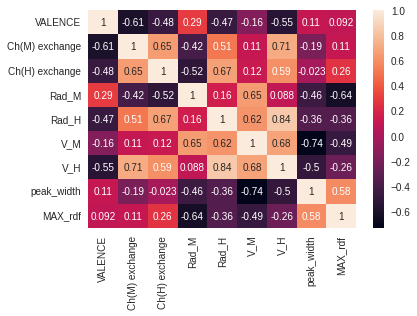

In [194]:
import seaborn as sn
corrMatrix = X_mdf.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [195]:
features = X_mdf.keys() 
print(features)

Index(['VALENCE', 'Ch(M) exchange', 'Ch(H) exchange', 'Rad_M', 'Rad_H', 'V_M',
       'V_H', 'peak_width', 'MAX_rdf'],
      dtype='object')


In [196]:
X_f=[]
for i in range (0,len(features)):
    X_f.append(features[i])
print(X_f)
# X_f[33]='Radius M Ch.'
# X_f[34]='Radius H Ch.'
X_f[-2]='RDF peak width'
X_f[-1]='RDF max'
X_f[-6]='Radius M Ch.'
X_f[-5]='Radius H Ch.'
X_f[-4]='Volume M Ch.'
X_f[-3]='Volume H Ch.'
print(X_f)

['VALENCE', 'Ch(M) exchange', 'Ch(H) exchange', 'Rad_M', 'Rad_H', 'V_M', 'V_H', 'peak_width', 'MAX_rdf']
['VALENCE', 'Ch(M) exchange', 'Ch(H) exchange', 'Radius M Ch.', 'Radius H Ch.', 'Volume M Ch.', 'Volume H Ch.', 'RDF peak width', 'RDF max']


In [197]:
fig = px.imshow(corrMatrix, x=X_f,y=X_f, text_auto=".1f")
fig.update_layout(coloraxis_colorbar_x=0.72)
# fig.show()
fig['layout'].update(xaxis=dict(tickfont = dict(size=34)),yaxis=dict(tickfont = dict(size=34)))
fig.update_coloraxes(colorbar_tickfont_size=34)
# plotly.offline.plot(fig, filename='./newpictures/DENSONLY/CorrelationMatrix.html')
fig.show()

# corrMatrix_submat_peaks = X_mdf.iloc[:, 23:31].corr()
# corrMatrix_submat_charges = X_mdf.iloc[:, 31:37].corr()

corrMatrix_submat_peaks = X_mdf.iloc[:, 16:24].corr()
corrMatrix_submat_charges = X_mdf.iloc[:, 24:30].corr()

fig = px.imshow(corrMatrix_submat_peaks,text_auto=".2f")
fig.update_layout(coloraxis_colorbar_x=0.9)
fig.show()

# fig = px.imshow(corrMatrix_submat_charges, x=X_f[31:37],y=X_f[31:37], text_auto=".2f")
fig = px.imshow(corrMatrix_submat_charges, x=X_f[24:30],y=X_f[24:30], text_auto=".2f")
fig.update_layout(coloraxis_colorbar_x=0.9)
fig.show()

# DIMENSIONALITY REDUCTION

#### DIMENSIONALITY REDUCTION: PCA

In [198]:
pca = PCA()

X_mdf_std_T=X_mdf_std

pca.fit(X_mdf_std_T)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print("Minimum number of dimensions to preserve 95% of training set variance: ",d)
d=np.arange(1,10,1,dtype='int')

print(cumsum,len(cumsum),d,len(d)) 

#plt.plot(d,cumsum,'b-o')
#plt.style.use('ggplot')
#plt.xlabel('d')
#plt.ylabel('Explained Variance Ratio')
#plt.show()

EXPVARRAT_DF = {'Explained Variance Ratio':cumsum,
         'Dimension':d}
 
# Create DataFrame
EXPVARRAT_DF = pd.DataFrame(EXPVARRAT_DF)
import plotly.express as px
#df = px.data.gapminder().query("continent == 'Oceania'")
fig = px.line(EXPVARRAT_DF, x='Dimension', y='Explained Variance Ratio')
fig.update_layout(
    #height=800,
    title_text='OCTA+TETRA CASE: Min. number of dimensions to preserve 95% of training set variance: 7'
)

fig.show()
#plotly.offline.plot(fig, filename='/Users/dariomassa/Documents/PHD_NCBJ/FCC_new/SPIN_CHECK/PCA_OUT_MINDIM_'+suffix+'.html')

Minimum number of dimensions to preserve 95% of training set variance:  6
[0.44353279 0.76370762 0.84173697 0.90447184 0.94762065 0.98139375
 0.99110052 0.99643956 1.        ] 9 [1 2 3 4 5 6 7 8 9] 9


/tmp/ipykernel_80251/2647251653.py:7: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



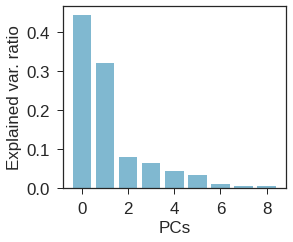

In [199]:
pca.get_covariance()

explained_variance=pca.explained_variance_ratio_
explained_variance

with plt.style.context('seaborn-white'):
    plt.style.use('seaborn-ticks')
    plt.figure(figsize=(5, 6))
    # plt.rcParams.update({'font.size': 50})
    plt.bar(range(9), explained_variance, alpha=0.5, align='center')
    plt.ylabel('Explained var. ratio', fontsize=17)
    plt.xlabel('PCs', fontsize=17)
    # plt.legend(loc='best')
    plt.tight_layout()
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.subplots_adjust(left=0.28, right=0.9, top=0.7, bottom=0.28)
    
plt.savefig('./newpictures/DENSONLY/Explained_Variance_DENSONLY.pdf')

In [200]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [201]:
#print(df['VALENCE'])

pca = PCA()
pca.fit(X_mdf_std_T)
X_PCA = pca.transform(X_mdf_std_T)

#print(pca.components_.T[:, 0])
#print(pca.components_.T[:, 1])
#print(pca.components_.T[:, 2])
C1=X_PCA[:,0]
C2=X_PCA[:,1]

print(C1.shape)

# crystalnames=[]
marker=[]
marker_explicit=[]

for pp in range (1,46):
    if pp==7 or pp==26 or pp==38 or pp==14 or pp==28 or pp==18 or pp==24:
        continue
        
    if pp==6 or pp==32 or pp==12:
        continue
        
    # crystalnames.append(crystal(pp))
    marker.append('OI')
    marker_explicit.append('circle')
    
for pp in range (1,46):
    if pp==7 or pp==26 or pp==38 or pp==14 or pp==28 or pp==18 or pp==24:
        continue
        
    if pp==6 or pp==32 or pp==12:
        continue
        
    # crystalnames.append(crystal(pp))
    marker.append('TI')
    marker_explicit.append('star-triangle-down')

crystalnames=[]

for pp in range (1,46):
    if pp==7 or pp==26 or pp==38 or pp==14 or pp==28 or pp==18 or pp==24:
        continue
        
    if pp==6 or pp==32 or pp==12:
        continue  
    crystalnames.append(crystal(pp))
for pp in range (1,46):
    if pp==7 or pp==26 or pp==38 or pp==14 or pp==28 or pp==18 or pp==24:
        continue
        
    if pp==6 or pp==32 or pp==12:
        continue
    crystalnames.append(crystal(pp))      

# print(crystalnames)

PC_COMPS_2D = {
'PC1':C1,
'PC2':C2,
}

df_COMPS_2D=pd.DataFrame.from_dict(PC_COMPS_2D)
    
PC_COMPS_2D_half1 = {
'PC1':C1[:35],
'PC2':C2[:35],
}

PC_COMPS_2D_half2 = {
'PC1':C1[35:70],
'PC2':C2[35:70],
}
    
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=10),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=20),
    titlefont = dict(size=34)
)
axis_template_z=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=20),
    titlefont = dict(size=34)
)


fig = px.scatter(PC_COMPS_2D, x='PC1', y='PC2', title="OT and IT PCA",text=crystalnames,symbol=marker)
#fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',xaxis=axis_template_x,yaxis=axis_template_y,zaxis=axis_template_z)
#fig.update_traces(marker_size = 3)
fig.update_layout(
    xaxis=axis_template_x,
  font={"size":20})
fig.update_layout(
                 scene = dict(
                                xaxis = dict(
                                     linewidth=1,
                                     tickfont = dict(size=5),
                                     backgroundcolor="rgba(0, 0, 0,0)",
                                     gridcolor="grey",
                                     showbackground=True,
                                     zerolinecolor="white",),
                                yaxis = dict(
                                     linewidth=1,
                                    tickfont = dict(size=5),
                                    backgroundcolor="rgba(0, 0, 0,0)",
                                    gridcolor="grey",
                                    showbackground=True,
                                    zerolinecolor="white"),
                                zaxis = dict(
                                     linewidth=1,
                                    tickfont = dict(size=5),
                                    backgroundcolor="rgba(0, 0, 0,0)",
                                    gridcolor="grey",
                                    showbackground=True,
                                    zerolinecolor="white",),),
                 )  
fig.update_layout(legend=dict(
    yanchor="top",
    y=1.00,
    xanchor="right",
    x=-0.05
))
fig.show()
#plotly.offline.plot(fig, filename='./newpictures/2D_PCA_OUT_densonly_plot_preliminary.html')



(70,)


#### DIMENSIONALITY REDUCTION: TSNE

In [202]:
from sklearn.manifold import TSNE

tsne_3 = TSNE(n_components=3, perplexity=5,init='random',learning_rate='auto')
X_embedded_3 = tsne_3.fit_transform(X_mdf_std)

tsne_2 = TSNE(n_components=2, perplexity=5,init='random',learning_rate='auto')
X_embedded_2 = tsne_2.fit_transform(X_mdf_std)

In [203]:


tsne_3_EMB1=np.array(X_embedded_3[:,0])
tsne_3_EMB2=np.array(X_embedded_3[:,1])
tsne_3_EMB3=np.array(X_embedded_3[:,2])

tsne_2_EMB1=np.array(X_embedded_2[:,0])
tsne_2_EMB2=np.array(X_embedded_2[:,1])

tsne_3_EMB_half1 = {'EMB1':tsne_3_EMB1[:35],
         'EMB2':tsne_3_EMB2[:35],
         'EMB3':tsne_3_EMB3[:35],
          'Hrad': np.array(result['Rad_H'])[:35],
          'Mrad':np.array(result['Rad_M'])[:35],
          'Atomic Radius':np.array(result['Atomic Radius'])[:35],
          'Atomic Number':np.array(result['Atomic Number'])[:35],
          'VALENCE':np.array(result['VALENCE'])[:35],
          'B(kbar)':np.array(result['BULKM'])[:35],

        }

tsne_3_EMB_half2 = {'EMB1':tsne_3_EMB1[35:70],
         'EMB2':tsne_3_EMB2[35:70],
         'EMB3':tsne_3_EMB3[35:70],
          'Hrad': np.array(result['Rad_H'])[35:70],
          'Mrad':np.array(result['Rad_M'])[35:70],
          'Atomic Radius':np.array(result['Atomic Radius'])[35:70],
          'Atomic Number':np.array(result['Atomic Number'])[35:70],
          'VALENCE':np.array(result['VALENCE'])[35:70],
          'B(kbar)':np.array(result['BULKM'])[35:70],


        }

tsne_2_EMB_half1 = {'EMB1':tsne_2_EMB1[:35],
         'EMB2':tsne_2_EMB2[:35],
          'Hrad': np.array(result['Rad_H'])[:35],
          'Mrad':np.array(result['Rad_M'])[:35],
          'Atomic Radius':np.array(result['Atomic Radius'])[:35],
          'Atomic Number':np.array(result['Atomic Number'])[:35],
          'VALENCE':np.array(result['VALENCE'])[:35],
          'B(kbar)':np.array(result['BULKM'])[:35],

        }

tsne_2_EMB_half2 = {'EMB1':tsne_2_EMB1[35:70],
         'EMB2':tsne_2_EMB2[35:70],
          'Hrad': np.array(result['Rad_H'])[35:70],
          'Mrad':np.array(result['Rad_M'])[35:70],
          'Atomic Radius':np.array(result['Atomic Radius'])[35:70],
          'Atomic Number':np.array(result['Atomic Number'])[35:70],
          'VALENCE':np.array(result['VALENCE'])[35:70],
          'B(kbar)':np.array(result['BULKM'])[35:70],

        }


# axis_template_x=dict(
#     linecolor='black',
#     linewidth=2,
#     title="EMB1",
#     tickfont = dict(size=20),
#     titlefont = dict(size=34)
# )
# axis_template_y=dict(
#     linecolor='black',
#     linewidth=2,
#     tickfont = dict(size=20),
#     titlefont = dict(size=34),
#     title="EMB2"
# )

# trace1=go.Scatter3d(x=PC_EMB_half1['EMB1'],y=PC_EMB_half1['EMB2'],z=PC_EMB_half1['EMB3'],text=crystalnames,mode="markers+text",marker=dict(symbol='circle',showscale=True,color=PC_DF_half1["VALENCE"],colorbar=dict(title="VALENCE")),name="OI")
# trace2=go.Scatter3d(x=PC_EMB_half2['EMB1'],y=PC_EMB_half2['EMB2'],z=PC_EMB_half2['EMB3'],text=crystalnames,mode="markers+text",marker=dict(symbol='diamond',showscale=True,color=PC_DF_half1["VALENCE"],colorbar=dict(title="VALENCE")),name="TI")

#trace1=go.Scatter(x=PC_DF_half1['EMB1'],y=PC_DF_half1['EMB2'],text=crystalnames,mode="markers+text",marker=dict(symbol='circle',color='green'),name="OI")
#trace2=go.Scatter(x=PC_DF_half2['EMB1'],y=PC_DF_half2['EMB2'],text=crystalnames,mode="markers+text",marker=dict(symbol='circle',color='red'),name="TI")


In [204]:
# data=[trace1,trace2]

# fig = go.Figure(data=[trace1, trace2])

# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=1.00,
#     xanchor="right",
#     x=-0.05
# ))
# fig.update_layout(showlegend=True)
# fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
# fig['layout'].update({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
# fig.update_traces(textposition='bottom center',textfont_size=34)
# fig.update_layout(title='3D TSNE with feature colouring',font={"size":21})
# fig.update_traces(marker=dict(size=12,line=dict(width=2)))
# fig.show()

# CLUSTERING

!pip install yellowbrick

### KMEANS

In [205]:
from sklearn.cluster import KMeans

# k_means_2_tot=KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(X_mdf_std)
# labels_2_tot=k_means_2_tot.labels_
# print(labels_2_tot)
# print(len(labels_2_tot))

# k_means_3_tot=KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(X_mdf_std)
# labels_3_tot=k_means_3_tot.labels_
# print(labels_3_tot)
# print(len(labels_3_tot))

# k_means_4_tot=KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(X_mdf_std)
# labels_4_tot=k_means_4_tot.labels_
# print(labels_4_tot)
# print(len(labels_4_tot))

# k_means_7_tot=KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(X_mdf_std)
# labels_7_tot=k_means_7_tot.labels_
# print(labels_7_tot)
# print(len(labels_7_tot))

# ///////////////////////////////////////////////////////////////

k_means_2_2DPCA=KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(df_COMPS_2D)
labels_2_2DPCA=k_means_2_2DPCA.labels_
print(labels_2_2DPCA)
print(len(labels_2_2DPCA))

# k_means_3_2DPCA=KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(df_COMPS_2D)
# labels_3_2DPCA=k_means_3_2DPCA.labels_
# print(labels_3_2DPCA)
# print(len(labels_3_2DPCA))

# k_means_4_2DPCA=KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(df_COMPS_2D)
# labels_4_2DPCA=k_means_4_2DPCA.labels_
# print(labels_4_2DPCA)
# print(len(labels_4_2DPCA))

# k_means_5_2DPCA=KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(df_COMPS_2D)
# labels_5_2DPCA=k_means_5_2DPCA.labels_
# print(labels_5_2DPCA)
# print(len(labels_5_2DPCA))

# k_means_6_2DPCA=KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(df_COMPS_2D)
# labels_6_2DPCA=k_means_6_2DPCA.labels_
# print(labels_6_2DPCA)
# print(len(labels_6_2DPCA))

k_means_7_2DPCA=KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(df_COMPS_2D)
labels_7_2DPCA=k_means_7_2DPCA.labels_
print(labels_7_2DPCA)
print(len(labels_7_2DPCA))

# k_means_8_2DPCA=KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(df_COMPS_2D)
# labels_8_2DPCA=k_means_8_2DPCA.labels_
# print(labels_8_2DPCA)
# print(len(labels_8_2DPCA))

[0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0
 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1]
70
[0 6 0 2 0 0 0 3 6 3 0 1 2 0 3 3 3 3 0 1 5 5 3 3 3 3 3 0 5 1 3 4 5 5 4 6 6
 0 2 0 5 0 3 1 5 5 1 2 0 3 3 5 5 5 1 5 5 5 5 3 5 5 3 5 1 3 4 5 5 4]
70


/tmp/ipykernel_80251/177414674.py:27: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



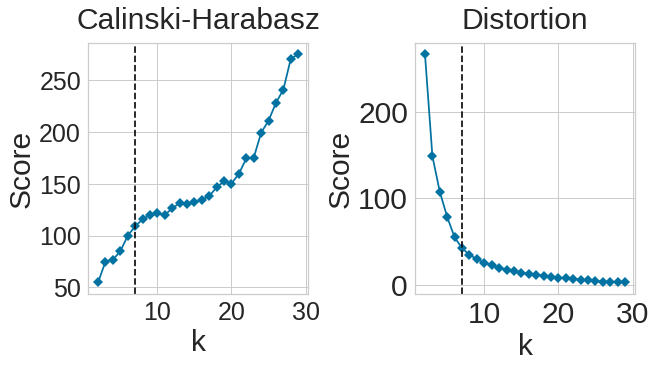

In [206]:
fig, axs = plt.subplots(figsize=(9, 5),nrows=1, ncols=2, constrained_layout=True)

model = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')

i=0
for ax in axs.flat:
    i+=1
    if i==1:
        ax.set_xlabel('k', fontsize=30)
        ax.set_ylabel('Score', fontsize=30)
        ax.set_title('Calinski-Harabasz', fontsize=30,y=1.0, pad=+14)
        ax.tick_params(axis='both', which='major', labelsize=25)
        # ax.tick_params(axis='both', which='minor', labelsize=30)
        visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= False, ax=ax)
        visualizer.fit(df_COMPS_2D)
    if i==2:
        ax.set_xlabel('k', fontsize=30)
        ax.set_ylabel('Score', fontsize=30)
        ax.set_title('Distortion', fontsize=30, y=1.0, pad=+14)
        ax.tick_params(axis='both', which='major', labelsize=30)
        # ax.tick_params(axis='both', which='minor', labelsize=30)
        visualizer = KElbowVisualizer(model, k=(2,30), timings= False, ax=ax)
        visualizer.fit(df_COMPS_2D)        # Fit data to visualizer
        
# plt.subplots_adjust(bottom=0.1, right=1.0, top=0.9)

fig.show()
# plt.savefig('./newpictures/Scores_KMEANS_bestN_DENSONLY.png')

/tmp/ipykernel_80251/3544966311.py:13: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



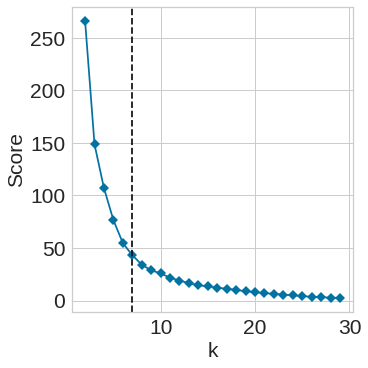

In [207]:
fig, ax = plt.subplots(figsize=(5, 5),nrows=1, ncols=1, constrained_layout=True)

ax.set_xlabel('k', fontsize=21)
ax.set_ylabel('Score', fontsize=21)
# ax.set_title('Elbow', fontsize=21, y=1.0, pad=+14)
ax.tick_params(axis='both', which='major', labelsize=21)
# ax.tick_params(axis='both', which='minor', labelsize=30)
visualizer = KElbowVisualizer(model, k=(2,30), timings= False, ax=ax)
visualizer.fit(df_COMPS_2D)        # Fit data to visualizer
        
# plt.subplots_adjust(bottom=0.1, right=1.0, top=0.9)

fig.show()
plt.savefig('./newpictures/Scores_KMEANS_bestN_1_DENSONLY.png')

In [208]:
# pd.DataFrame(pca.components_.T)

### Gaussian Mixture

In [209]:
from sklearn.mixture import GaussianMixture

# G_M_PCA_DF={'PC1':C1,
#             'PC2':C2,
#             'PC3':C3}
# G_M_PCA_DF=pd.DataFrame.from_dict(G_M_PCA_DF)

# gmix_2_tot=GaussianMixture(n_components=2,random_state=0).fit_predict(X_mdf_std)

# gmix_3_tot=GaussianMixture(n_components=3,random_state=0).fit_predict(X_mdf_std)

# gmix_4_tot=GaussianMixture(n_components=4,random_state=0).fit_predict(X_mdf_std)

# gmix_7_tot=GaussianMixture(n_components=7,random_state=0).fit_predict(X_mdf_std)

# print(gmix_2_tot)
# print(gmix_3_tot)
# print(gmix_4_tot)
# print(gmix_7_tot)

gmix_2_2DPCA=GaussianMixture(n_components=2,random_state=0).fit_predict(df_COMPS_2D)

# gmix_3_2DPCA=GaussianMixture(n_components=3,random_state=0).fit_predict(df_COMPS_2D)

# gmix_4_2DPCA=GaussianMixture(n_components=4,random_state=0).fit_predict(df_COMPS_2D)

# gmix_5_2DPCA=GaussianMixture(n_components=5,random_state=0).fit_predict(df_COMPS_2D)

# gmix_6_2DPCA=GaussianMixture(n_components=6,random_state=0).fit_predict(df_COMPS_2D)

gmix_7_2DPCA=GaussianMixture(n_components=7,random_state=0).fit_predict(df_COMPS_2D)

# gmix_8_2DPCA=GaussianMixture(n_components=8,random_state=0).fit_predict(df_COMPS_2D)

print(gmix_2_2DPCA)
# print(gmix_3_2DPCA)
# print(gmix_4_2DPCA)
# print(gmix_5_2DPCA)
# print(gmix_6_2DPCA)
print(gmix_7_2DPCA)
# print(gmix_8_2DPCA)

# fig = px.scatter_3d(PC_COMPS, x='PC1', y='PC2', z='PC3', title="Gaussian-Mixture on PCA reduced space",text="crystal",color=gmix,symbol=marker)
# #fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',xaxis=axis_template_x,yaxis=axis_template_y,zaxis=axis_template_z)
# #fig.update_traces(marker_size = 3)
# fig.update_layout(
#     xaxis=axis_template_x,
#   font={"size":20})
# fig.update_layout(
#                  scene = dict(
#                                 xaxis = dict(
#                                      linewidth=1,
#                                      tickfont = dict(size=5),
#                                      backgroundcolor="rgba(0, 0, 0,0)",
#                                      gridcolor="grey",
#                                      showbackground=True,
#                                      zerolinecolor="white",),
#                                 yaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white"),
#                                 zaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white",),),
#                  )  

# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=1.00,
#     xanchor="right",
#     x=0.32
# ))

# fig.show()
# #plotly.offline.plot(fig, filename='./GM+PCA.html')

[0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1
 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1]
[4 6 4 1 4 4 4 5 3 5 4 3 1 4 5 5 5 5 4 3 0 0 5 5 5 5 5 4 0 3 5 2 0 0 2 6 6
 4 1 4 0 4 5 3 0 0 3 1 4 5 5 0 0 0 3 0 0 0 0 5 0 0 5 0 3 5 2 0 0 2]


In [210]:
# init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto'

# PLOTTING

In [211]:
X = X_mdf_std

pca = PCA(n_components=2)
components = pca.fit_transform(X)
components.shape

(70, 2)

In [212]:
def confidence_ellipse(x, y, n_std=1.96, size=100):
    """
    Get the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    size : int
        Number of points defining the ellipse
    Returns
    -------
    String containing an SVG path for the ellipse
    
    References (H/T)
    ----------------
    https://matplotlib.org/3.1.1/gallery/statistics/confidence_ellipse.html
    https://community.plotly.com/t/arc-shape-with-path/7205/5
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    theta = np.linspace(0, 2 * np.pi, size)
    ellipse_coords = np.column_stack([ell_radius_x * np.cos(theta), ell_radius_y * np.sin(theta)])
    
    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    x_scale = np.sqrt(cov[0, 0]) * n_std
    x_mean = np.mean(x)

    # calculating the stdandard deviation of y ...
    y_scale = np.sqrt(cov[1, 1]) * n_std
    y_mean = np.mean(y)
  
    translation_matrix = np.tile([x_mean, y_mean], (ellipse_coords.shape[0], 1))
    rotation_matrix = np.array([[np.cos(np.pi / 4), np.sin(np.pi / 4)],
                                [-np.sin(np.pi / 4), np.cos(np.pi / 4)]])
    scale_matrix = np.array([[x_scale, 0],
                            [0, y_scale]])
    ellipse_coords = ellipse_coords.dot(rotation_matrix).dot(scale_matrix) + translation_matrix
        
    path = f'M {ellipse_coords[0, 0]}, {ellipse_coords[0, 1]}'
    for k in range(1, len(ellipse_coords)):
        path += f'L{ellipse_coords[k, 0]}, {ellipse_coords[k, 1]}'
    path += ' Z'
    return path

fig = go.Figure()

fig.add_trace(
    go.Scatter( #PC_COMPS_2D_half1['PC1']
        x=components[:35,0], y=components[:35,1],text=crystalnames[:35],
        mode="markers+text",marker=dict(size=11.5,opacity=0.7,symbol="circle",showscale=False,color='blue'),name="OI"
    )
)

fig.add_trace(
    go.Scatter(
        x=components[35:70,0], y=components[35:70,1],text=crystalnames[35:70],
        mode="markers+text",marker=dict(size=11.5,opacity=0.7,symbol="star-triangle-down",color='red'),name="TI"
    )
)

fig.add_shape(type='path',
              path=confidence_ellipse(components[:35,0], components[:35,1]),
              line={'dash': 'dot'},
              line_color='blue')
    
fig.add_shape(type='path',
              path=confidence_ellipse(components[35:70,0], components[35:70,1]),
              line={'dash': 'dot'},
               line_color='red')

axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)

axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(width=800, height=800,xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_layout(font={"size":34})
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=-0.02
))

fig.show()
# plotly.offline.plot(fig, filename='./newpictures/DENSONLY/Visual_Clustering_OITI_DENSONLY.html')

In [213]:
# KMEANS CLUSTERS
positions=np.where(labels_7_2DPCA==0)
# print(positions)
for pos in positions:
    clust_0_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_0_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(labels_7_2DPCA==1)
# print(positions)
for pos in positions:
    clust_1_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_1_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(labels_7_2DPCA==2)
# print(positions)
for pos in positions:
    clust_2_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_2_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(labels_7_2DPCA==3)
# print(positions)
for pos in positions:
    clust_3_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_3_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(labels_7_2DPCA==4)
# print(positions)
for pos in positions:
    clust_4_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_4_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(labels_7_2DPCA==5)
# print(positions)
for pos in positions:
    clust_5_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_5_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]
    
positions=np.where(labels_7_2DPCA==6)
# print(positions)
for pos in positions:
    clust_6_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_6_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]
    
#     ------------------------------------------------------------------------------

# GM CLUSTERS
positions=np.where(gmix_7_2DPCA==0)
# print(positions)
for pos in positions:
    clust_0_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_0_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(gmix_7_2DPCA==1)
# print(positions)
for pos in positions:
    clust_1_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_1_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(gmix_7_2DPCA==2)
# print(positions)
for pos in positions:
    clust_2_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_2_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(gmix_7_2DPCA==3)
# print(positions)
for pos in positions:
    clust_3_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_3_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(gmix_7_2DPCA==4)
# print(positions)
for pos in positions:
    clust_4_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_4_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(gmix_7_2DPCA==5)
# print(positions)
for pos in positions:
    clust_5_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_5_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(gmix_7_2DPCA==6)
# print(positions)
for pos in positions:
    clust_6_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_6_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

    

trace1=go.Scatter(x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="circle",showscale=True,color=labels_7_2DPCA,colorbar=dict(title=".",x=0.44),colorscale='Turbo'),name="OI")
trace2=go.Scatter(x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="star-triangle-down",color=labels_7_2DPCA,colorscale='Turbo'),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="circle",showscale=True,color=gmix_7_2DPCA,colorbar=dict(title="."),colorscale='Turbo'),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="star-triangle-down",color=gmix_7_2DPCA,colorscale='Turbo'),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=7)',  'Gaussian-Mixture(n=7)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)

fig.add_shape(type='path',
              path=confidence_ellipse(clust_0_KM_PC1, clust_0_KM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(98,83,119)',row=1,col=1) #rgb(98,83,119) GREY

fig.add_shape(type='path',
              path=confidence_ellipse(clust_1_KM_PC1, clust_1_KM_PC2),
              line={'dash': 'dot'},
              line_color='#3283FE',row=1,col=1) # #3283FE light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_2_KM_PC1, clust_2_KM_PC2),
              line={'dash': 'dot'},
              line_color='#19D3F3',row=1,col=1) # #19D3F3 very light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_3_KM_PC1, clust_3_KM_PC2),
              line={'dash': 'dot'},
              line_color='#16FF32',row=1,col=1) #very light green

fig.add_shape(type='path',
              path=confidence_ellipse(clust_4_KM_PC1, clust_4_KM_PC2),
              line={'dash': 'dot'},
              line_color='#EECA3B',row=1,col=1) #stupid yellow

fig.add_shape(type='path',
              path=confidence_ellipse(clust_5_KM_PC1, clust_5_KM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(217,95,2)',row=1,col=1) #rgb(217,95,2) arancio scuro

fig.add_shape(type='path',
              path=confidence_ellipse(clust_6_KM_PC1, clust_6_KM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(217,95,2)',row=1,col=1) # rgb(102,17,0) marrone

# ----------------------------------------------------------------------------------------

fig.add_shape(type='path',
              path=confidence_ellipse(clust_0_GM_PC1, clust_0_GM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(98,83,119)',row=1,col=2) #rgb(98,83,119) GREY

fig.add_shape(type='path',
              path=confidence_ellipse(clust_1_GM_PC1, clust_1_GM_PC2),
              line={'dash': 'dot'},
              line_color='#3283FE',row=1,col=2) #3283FE light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_2_GM_PC1, clust_2_GM_PC2),
              line={'dash': 'dot'},
              line_color='#19D3F3',row=1,col=2) #19D3F3 very light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_3_GM_PC1, clust_3_GM_PC2),
              line={'dash': 'dot'},
              line_color='#16FF32',row=1,col=2) #very light green

fig.add_shape(type='path',
              path=confidence_ellipse(clust_4_GM_PC1, clust_4_GM_PC2),
              line={'dash': 'dot'},
              line_color='#EECA3B',row=1,col=2) #stupid yellow

fig.add_shape(type='path',
              path=confidence_ellipse(clust_5_GM_PC1, clust_5_GM_PC2),
              line={'dash': 'dot'},
              line_color='orange',row=1,col=2) # rgb(217,95,2) arancio scuro

fig.add_shape(type='path',
              path=confidence_ellipse(clust_6_GM_PC1, clust_6_GM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(217,95,2)',row=1,col=2) # rgb(102,17,0) marrone

# fig.show()
# print(confidence_ellipse(clust_6_KM_PC1, clust_6_KM_PC2))
# plotly.offline.plot(fig, filename='./newpictures/DENSONLY/clust7_DENSONLY.html')

In [214]:
fig = px.colors.qualitative.swatches()
fig.show()
# rgb(166,216,84) verde chiaro
# 217,95,2 arancio scuro


tosave_DICT_OI={
'crystal':crystalnames[:45],
'VALENCE' : np.array(result['VALENCE'])[:45],
'peak1_pos' : np.array(result['peak1_pos'])[:45],
'peak1_height' : np.array(result['peak1_height'])[:45],
'peak1_width' : np.array(result['peak1_width'])[:45],
'Rad_H' : np.array(result['Rad_H'])[:45],
'BULKM' : np.array(result['BULKM'])[:45],
'PC1':C1[:45],
'PC2':C2[:45],
'PC3':C3[:45],
'PC4':C4[:45],
'PC5':C5[:45],
'PC6':C6[:45],
'PC7':C7[:45],
'PC8':C8[:45],
'PC9':C9[:45],
'PC10':C10[:45],
'PC11':C11[:45],
'PC12':C12[:45],
'EMB1_2D':tsne_2_EMB1[:45],
'EMB2_2D':tsne_2_EMB2[:45],
'GM_2':gmix_2_tot[:45],
'GM_3':gmix_3_tot[:45],
'GM_4':gmix_4_tot[:45],    
'GM_7':gmix_7_tot[:45],
'KM_2':labels_2_2DPCA[:45],  
'KM_3':labels_3_2DPCA[:45],
'KM_4':labels_4_2DPCA[:45],  
'KM_7':labels_7_2DPCA[:45]
}
tosave_DF_OI=pd.DataFrame.from_dict(tosave_DICT_OI)
tosave_DF_OI.to_csv('ML_plotting_OI.csv', index=False) 

tosave_DICT_TI={
'crystal':crystalnames[45:90],
'VALENCE' : np.array(result['VALENCE'])[45:90],
'peak1_pos' : np.array(result['peak1_pos'])[45:90],
'peak1_height' : np.array(result['peak1_height'])[45:90],
'peak1_width' : np.array(result['peak1_width'])[45:90],
'Rad_H' : np.array(result['Rad_H'])[45:90],
'BULKM' : np.array(result['BULKM'])[45:90],
'PC1':C1[45:90],
'PC2':C2[45:90],
'PC3':C3[45:90],
'PC4':C4[45:90],
'PC5':C5[45:90],
'PC6':C6[45:90],
'PC7':C7[45:90],
'PC8':C8[45:90],
'PC9':C9[45:90],
'PC10':C10[45:90],
'PC11':C11[45:90],
'PC12':C12[45:90],
'EMB1_2D':tsne_2_EMB1[45:90],
'EMB2_2D':tsne_2_EMB2[45:90],
'GM_2':gmix_2_tot[45:90],
'GM_3':gmix_3_tot[45:90],
'GM_4':gmix_4_tot[45:90],    
'GM_7':gmix_7_tot[45:90],
'KM_2':labels_2_2DPCA[45:90],  
'KM_3':labels_3_2DPCA[45:90],
'KM_4':labels_4_2DPCA[45:90],  
'KM_7':labels_7_2DPCA[45:90]
}
tosave_DF_TI=pd.DataFrame.from_dict(tosave_DICT_TI)
tosave_DF_TI.to_csv('ML_plotting_TI.csv', index=False) 

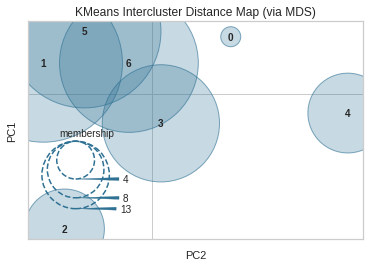

<AxesSubplot: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [215]:
from yellowbrick.cluster import InterclusterDistance

# Generate synthetic dataset with 12 random clusters
# X, y = make_blobs(n_samples=1000, n_features=12, centers=12, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
visualizer = InterclusterDistance(model)

visualizer.fit(df_COMPS_2D)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [216]:
for i in range (0,35):
    print(i,crystalnames[i],labels_7_2DPCA[i],crystalnames[i],labels_7_2DPCA[i+35])
#[(i,crystalnames[i],labels_7_2DPCA[i],crystalnames[i],labels_7_2DPCA[i+34]) for i in range (1,36)]
#print(crystalnames)
for i in range (0,35):
    print(i,crystalnames[i],gmix_7_2DPCA[i],crystalnames[i],gmix_7_2DPCA[i+35])

0 Tl 0 Tl 6
1 Pb 6 Pb 6
2 Sn 0 Sn 0
3 Rb 2 Rb 2
4 In 0 In 0
5 Zr 0 Zr 5
6 Y 0 Y 0
7 Ta 3 Ta 3
8 Sr 6 Sr 1
9 Re 3 Re 5
10 Nb 0 Nb 5
11 Na 1 Na 1
12 K 2 K 2
13 Cd 0 Cd 0
14 Ag 3 Ag 3
15 Rh 3 Rh 3
16 Os 3 Os 5
17 Mo 3 Mo 5
18 Sc 0 Sc 5
19 Mg 1 Mg 1
20 V 5 V 5
21 Ti 5 Ti 5
22 Tc 3 Tc 5
23 Ru 3 Ru 5
24 Pt 3 Pt 3
25 Pd 3 Pd 5
26 Ir 3 Ir 5
27 Ge 0 Ge 3
28 Cr 5 Cr 5
29 Ca 1 Ca 1
30 Au 3 Au 3
31 Al 4 Al 4
32 Mn 5 Mn 5
33 Cu 5 Cu 5
34 Li 4 Li 4
0 Tl 4 Tl 6
1 Pb 6 Pb 6
2 Sn 4 Sn 4
3 Rb 1 Rb 1
4 In 4 In 4
5 Zr 4 Zr 0
6 Y 4 Y 4
7 Ta 5 Ta 5
8 Sr 3 Sr 3
9 Re 5 Re 0
10 Nb 4 Nb 0
11 Na 3 Na 3
12 K 1 K 1
13 Cd 4 Cd 4
14 Ag 5 Ag 5
15 Rh 5 Rh 5
16 Os 5 Os 0
17 Mo 5 Mo 0
18 Sc 4 Sc 0
19 Mg 3 Mg 3
20 V 0 V 0
21 Ti 0 Ti 0
22 Tc 5 Tc 0
23 Ru 5 Ru 0
24 Pt 5 Pt 5
25 Pd 5 Pd 0
26 Ir 5 Ir 0
27 Ge 4 Ge 5
28 Cr 0 Cr 0
29 Ca 3 Ca 3
30 Au 5 Au 5
31 Al 2 Al 2
32 Mn 0 Mn 0
33 Cu 0 Cu 0
34 Li 2 Li 2


marker_explicit=[]

for pp in range (1,46):
    if pp==7 or pp==26 or pp==38 or pp==14 or pp==28 or pp==18 or pp==24:
        continue
        
    if pp==6 or pp==32 or pp==12:
        continue
        
    # crystalnames.append(crystal(pp))
    marker.append('OI')
    marker_explicit.append('circle')
    
for pp in range (1,46):
    if pp==7 or pp==26 or pp==38 or pp==14 or pp==28 or pp==18 or pp==24:
        continue
        
    if pp==6 or pp==32 or pp==12:
        continue
        
    # crystalnames.append(crystal(pp))
    marker.append('TI')
    marker_explicit.append('star-triangle-down')


In [224]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

features = X_mdf.keys() 

X = X_mdf_std

pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# data = StandardScaler().fit_transform(components)
data = scaler.fit_transform(components)
print(crystalnames)
fig = px.scatter(data, x=0, y=1, color=labels_7_2DPCA, color_continuous_scale='Turbo',opacity=0.4,text=crystalnames,width=1000, height=800, symbol=marker)
# fig.update_traces(marker=dict(size=15,showscale=False))
fig.update_traces(marker=dict(size=18,showscale=False,line=dict(width=3)))
fig.update_traces(textfont_size=15)
for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        line=dict(width=0.7),
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1],
        opacity=0.6
    )
    # angle=math.degrees(math.atan2(loadings[i, 1]-0, loadings[i, 0]-0))+45
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        font=dict(size=17),
        # bgcolor='grey'
        # textangle=angle
    )
    
fig.add_vline(x=0, line_width=0.7, line_dash="dash", line_color="black")
fig.add_hline(y=0, line_width=0.7, line_dash="dash", line_color="black")

axis_template_x=dict(
    linecolor='black',
    linewidth=1.5,
    title="PC1",
    tickfont = dict(size=23),
    titlefont = dict(size=23)
    
)

axis_template_y=dict(
    linecolor='black',
    linewidth=1.5,
    title="PC2",
    tickfont = dict(size=23),
    titlefont = dict(size=23)
    
)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.90
))
fig.update_layout(coloraxis_showscale=False)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})

# fig.show()
print(loadings,loadings.shape)
plotly.offline.plot(fig, filename='./newpictures/DENSONLY/LoadingsPlot_DENSONLY_1.html')

['Tl', 'Pb', 'Sn', 'Rb', 'In', 'Zr', 'Y', 'Ta', 'Sr', 'Re', 'Nb', 'Na', 'K', 'Cd', 'Ag', 'Rh', 'Os', 'Mo', 'Sc', 'Mg', 'V', 'Ti', 'Tc', 'Ru', 'Pt', 'Pd', 'Ir', 'Ge', 'Cr', 'Ca', 'Au', 'Al', 'Mn', 'Cu', 'Li', 'Tl', 'Pb', 'Sn', 'Rb', 'In', 'Zr', 'Y', 'Ta', 'Sr', 'Re', 'Nb', 'Na', 'K', 'Cd', 'Ag', 'Rh', 'Os', 'Mo', 'Sc', 'Mg', 'V', 'Ti', 'Tc', 'Ru', 'Pt', 'Pd', 'Ir', 'Ge', 'Cr', 'Ca', 'Au', 'Al', 'Mn', 'Cu', 'Li']
[[-0.60852799 -0.42969544]
 [ 0.66577223  0.57851315]
 [ 0.60464676  0.66609832]
 [ 0.1647599  -0.92971784]
 [ 0.90119631  0.04850045]
 [ 0.74233211 -0.55026588]
 [ 0.95824563  0.09672506]
 [-0.62662529  0.53302994]
 [-0.41138676  0.70522054]] (9, 2)


'./newpictures/DENSONLY/LoadingsPlot_DENSONLY_1.html'

In [221]:
from bokeh.models import (
    ColumnDataSource,
    LinearColorMapper,
    LogColorMapper,
    ColorBar,
    BasicTicker,
)
from bokeh.plotting import figure, output_file
from bokeh.io import show as show_
from bokeh.sampledata.periodic_table import elements
from bokeh.transform import dodge
from csv import reader
from matplotlib.colors import Normalize, LogNorm, to_hex
from matplotlib.cm import (
    plasma,
    inferno,
    magma,
    viridis,
    cividis,
    turbo,
    ScalarMappable,
)
from pandas import options
from typing import List
import warnings
def ptable_plotter(
    filename: str,
    show: bool = True,
    output_filename: str = None,
    width: int = 1050,
    cmap: str = "turbo",
    alpha: float = 0.65,
    extended: bool = True,
    periods_remove: List[int] = None,
    groups_remove: List[int] = None,
    log_scale: bool = False,
    cbar_height: float = None,
    cbar_standoff: int = 12,
    cbar_fontsize: int = 14,
    blank_color: str = "#c4c4c4",
    under_value: float = None,
    under_color: str = "#140F0E",
    over_value: float = None,
    over_color: str = "#140F0E",
    special_elements: List[str] = None,
    special_color: str = "#6F3023",
) -> figure:

    """
    Plot a heatmap over the periodic table of elements.

    Parameters
    ----------
    filename : str
        Path to the .csv file containing the data to be plotted.
    show : str
        If True, the plot will be shown.
    output_filename : str
        If not None, the plot will be saved to the specified (.html) file.
    width : float
        Width of the plot.
    cmap : str
        plasma, inferno, viridis, magma, cividis, turbo
    alpha : float
        Alpha value (transparency).
    extended : bool
        If True, the lanthanoids and actinoids will be shown.
    periods_remove : List[int]
        Period numbers to be removed from the plot.
    groups_remove : List[int]
        Group numbers to be removed from the plot.
    log_scale : bool
        If True, the colorbar will be logarithmic.
    cbar_height : int
        Height of the colorbar.
    cbar_standoff : int
        Distance between the colorbar and the plot.
    cbar_fontsize : int
        Fontsize of the colorbar label.
    blank_color : str
        Hexadecimal color of the elements without data.
    under_value : float
        Values <= under_value will be colored with under_color.
    under_color : str
        Hexadecimal color to be used for the lower bound color.
    over_value : float
        Values >= over_value will be colored with over_color.
    under_color : str
        Hexadecial color to be used for the upper bound color.
    special_elements: List[str]
        List of elements to be colored with special_color.
    special_color: str
        Hexadecimal color to be used for the special elements.

    Returns
    -------
    figure
        Bokeh figure object.
    """

    options.mode.chained_assignment = None

    # Assign color palette based on input argument
    if cmap == "plasma":
        cmap = plasma
        bokeh_palette = "Plasma256"
    elif cmap == "inferno":
        cmap = inferno
        bokeh_palette = "Inferno256"
    elif cmap == "magma":
        cmap = magma
        bokeh_palette = "Magma256"
    elif cmap == "viridis":
        cmap = viridis
        bokeh_palette = "Viridis256"
    elif cmap == "cividis":
        cmap = cividis
        bokeh_palette = "Cividis256"
    elif cmap == "turbo":
        cmap = turbo
        bokeh_palette = "Turbo256"
    else:
        ValueError("Invalid color map.")

    # Define number of and groups
    period_label = ["1", "2", "3", "4", "5", "6", "7"]
    group_range = [str(x) for x in range(1, 19)]

    # Remove any groups or periods
    if groups_remove:
        for gr in groups_remove:
            gr = gr.strip()
            group_range.remove(str(gr))
    if periods_remove:
        for pr in periods_remove:
            pr = pr.strip()
            period_label.remove(str(pr))

    # Read in data from CSV file
    data_elements = []
    data_list = []
    for row in reader(open(filename)):
        data_elements.append(row[0])
        data_list.append(row[1])
    data = [float(i) for i in data_list]

    if len(data) != len(data_elements):
        raise ValueError("Unequal number of atomic elements and data points")

    period_label.append("blank")
    period_label.append("La")
    period_label.append("Ac")

    if extended:
        count = 0
        for i in range(56, 70):
            elements.period[i] = "La"
            elements.group[i] = str(count + 4)
            count += 1

        count = 0
        for i in range(88, 102):
            elements.period[i] = "Ac"
            elements.group[i] = str(count + 4)
            count += 1

    # Define matplotlib and bokeh color map
    if log_scale:
        for datum in data:
            if datum < 0:
                raise ValueError(
                    f"Entry for element {datum} is negative but log-scale is selected"
                )
        color_mapper = LogColorMapper(
            palette=bokeh_palette, low=min(data), high=max(data)
        )
        norm = LogNorm(vmin=min(data), vmax=max(data))
    else:
        color_mapper = LinearColorMapper(
            palette=bokeh_palette, low=min(data), high=6
        )
        norm = Normalize(vmin=min(data), vmax=6)
    color_scale = ScalarMappable(norm=norm, cmap=cmap).to_rgba(data, alpha=None)

    # Set blank color
    color_list = [blank_color] * len(elements)

    # Compare elements in dataset with elements in periodic table
    for i, data_element in enumerate(data_elements):
        element_entry = elements.symbol[
            elements.symbol.str.lower() == data_element.lower()
        ]
        if element_entry.empty == False:
            element_index = element_entry.index[0]
        else:
            warnings.warn("Invalid chemical symbol: " + data_element)
        if color_list[element_index] != blank_color:
            warnings.warn("Multiple entries for element " + data_element)
        elif under_value is not None and data[i] <= under_value:
            color_list[element_index] = under_color
        elif over_value is not None and data[i] >= over_value:
            color_list[element_index] = over_color
        else:
            color_list[element_index] = to_hex(color_scale[i])

    if special_elements:
        for k, v in elements["symbol"].iteritems():
            if v in special_elements:
                color_list[k] = special_color

    # Define figure properties for visualizing data
    source = ColumnDataSource(
        data=dict(
            group=[str(x) for x in elements["group"]],
            period=[str(y) for y in elements["period"]],
            sym=elements["symbol"],
            atomic_number=elements["atomic number"],
            type_color=color_list,
        )
    )

    # Plot the periodic table
    p = figure(x_range=group_range, y_range=list(reversed(period_label)), tools="save")
    p.plot_width = width
    p.outline_line_color = None
    p.background_fill_color = None
    p.border_fill_color = None
    p.toolbar_location = "above"
    p.rect("group", "period", 0.9, 0.9, source=source, alpha=alpha, color="type_color")
    p.axis.visible = False
    text_props = {
        "source": source,
        "angle": 0,
        "color": "black",
        "text_align": "left",
        "text_baseline": "middle",
    }
    x = dodge("group", -0.4, range=p.x_range)
    y = dodge("period", 0.3, range=p.y_range)
    p.text(
        x=x,
        y="period",
        text="sym",
        text_font_style="bold",
        text_font_size="16pt",
        **text_props,
    )
    p.text(x=x, y=y, text="atomic_number", text_font_size="11pt", **text_props)

    color_bar = ColorBar(
        color_mapper=color_mapper,
        ticker=BasicTicker(desired_num_ticks=10),
        border_line_color=None,
        label_standoff=cbar_standoff,
        location=(0, 0),
        orientation="vertical",
        scale_alpha=alpha,
        major_label_text_font_size=f"{cbar_fontsize}pt",
    )

    if cbar_height is not None:
        color_bar.height = cbar_height

    p.add_layout(color_bar, "right")
    p.grid.grid_line_color = None

    if output_filename:
        output_file(output_filename)

    if show:
        show_(p)

    return p

label_info_7_KM_OI = pd.DataFrame(labels_7_2DPCA[:35],columns=['label'],index=crystalnames[:35])
label_info_7_KM_TI = pd.DataFrame(labels_7_2DPCA[35:70],columns=['label'],index=crystalnames[35:70])

print(label_info_7_KM_OI)
label_info_7_KM_OI.to_csv('pure_dens_labels_7KM_OI.csv', index=True,header=False) 
print(label_info_7_KM_TI)
label_info_7_KM_TI.to_csv('pure_dens_labels_7KM_TI.csv', index=True,header=False) 


    label
Tl      0
Pb      6
Sn      0
Rb      2
In      0
Zr      0
Y       0
Ta      3
Sr      6
Re      3
Nb      0
Na      1
K       2
Cd      0
Ag      3
Rh      3
Os      3
Mo      3
Sc      0
Mg      1
V       5
Ti      5
Tc      3
Ru      3
Pt      3
Pd      3
Ir      3
Ge      0
Cr      5
Ca      1
Au      3
Al      4
Mn      5
Cu      5
Li      4
    label
Tl      6
Pb      6
Sn      0
Rb      2
In      0
Zr      5
Y       0
Ta      3
Sr      1
Re      5
Nb      5
Na      1
K       2
Cd      0
Ag      3
Rh      3
Os      5
Mo      5
Sc      5
Mg      1
V       5
Ti      5
Tc      5
Ru      5
Pt      3
Pd      5
Ir      5
Ge      3
Cr      5
Ca      1
Au      3
Al      4
Mn      5
Cu      5
Li      4


In [222]:

ptable_plotter("pure_dens_labels_7KM_OI.csv",output_filename='OI_tableplot_pd',log_scale=False,show=True)


Figure(id='3284', ...)

In [223]:
ptable_plotter("pure_dens_labels_7KM_TI.csv",output_filename='TI_tableplot_pd', log_scale=False,show=True)

Figure(id='3474', ...)

In [128]:
# s = np.linspace(-1, 1, num=41)
# print(s)
# np.append(loadings, s, axis=1)
# print(loadings.shape)
loading_matrix = pd.DataFrame(loadings,columns=['PC1', 'PC2'],index=features)
# loading_matrix.loc[len(loading_matrix)] = s
print(loading_matrix)
loading_matrix.to_csv('loading_matrix_DENSONLY.csv', index=True) 


                     PC1       PC2
VALENCE        -0.608528 -0.429695
Ch(M) exchange  0.665772  0.578513
Ch(H) exchange  0.604647  0.666098
Rad_M           0.164760 -0.929718
Rad_H           0.901196  0.048500
V_M             0.742332 -0.550266
V_H             0.958246  0.096725
peak_width     -0.626625  0.533030
MAX_rdf        -0.411387  0.705221


In [209]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

features = X_mdf.keys() 

X = X_mdf_std

pca = PCA(n_components=4)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# data = StandardScaler().fit_transform(components)
data = scaler.fit_transform(components)

print(loadings[:,2:],loadings[:,2:].shape)

fig = px.scatter(data[:,2:], x=0, y=1, color=gmix_7_2DPCA, color_continuous_scale='Turbo',opacity=0.4,text=crystalnames,width=1000, height=800,symbol=marker)
fig.update_traces(marker=dict(size=15))
fig.update_traces(textfont_size=15)
for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        line=dict(width=0.7),
        x0=0, y0=0,
        x1=loadings[i, 2],
        y1=loadings[i, 3],
        opacity=0.6
    )
    fig.add_annotation(
        x=loadings[i, 2],
        y=loadings[i, 3],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        font=dict(size=17)
        # bgcolor='grey'
    )
    
fig.add_vline(x=0, line_width=0.7, line_dash="dash", line_color="black")
fig.add_hline(y=0, line_width=0.7, line_dash="dash", line_color="black")

axis_template_x=dict(
    linecolor='black',
    linewidth=1.5,
    title="PC3",
    tickfont = dict(size=23),
    titlefont = dict(size=23)
    
)

axis_template_y=dict(
    linecolor='black',
    linewidth=1.5,
    title="PC4",
    tickfont = dict(size=23),
    titlefont = dict(size=23)
    
)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.90
))
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(coloraxis_showscale=False)
fig.show()
print(loadings,loadings.shape)
#plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/LoadingsPlot_1_DENSONLY.html')

[[-0.43058845  0.45781818]
 [-0.06402127  0.15267803]
 [-0.46637201  0.62593836]
 [-0.08675545  0.00894558]
 [-0.82513937  0.14026918]
 [ 0.5228588   0.69550704]
 [-0.45039745  0.21765595]
 [ 0.5501205   0.67655993]
 [-0.24540866 -0.00956111]
 [ 0.29374033  0.43438413]
 [ 0.10673833 -0.37117743]
 [ 0.31549431  0.08103297]
 [ 0.56910872 -0.25012433]
 [ 0.45477231  0.00877966]] (14, 2)


[[ 0.64520533 -0.24573061 -0.43058845  0.45781818]
 [-0.82772713  0.42509973 -0.06402127  0.15267803]
 [ 0.51022936 -0.26161965 -0.46637201  0.62593836]
 [-0.80071948  0.47239517 -0.08675545  0.00894558]
 [ 0.2769301   0.34661753 -0.82513937  0.14026918]
 [-0.30321987 -0.3744194   0.5228588   0.69550704]
 [ 0.37164516  0.25294223 -0.45039745  0.21765595]
 [-0.28064235 -0.38789744  0.5501205   0.67655993]
 [-0.24301756 -0.70134811 -0.24540866 -0.00956111]
 [ 0.22610244  0.73001991  0.29374033  0.43438413]
 [ 0.55664411 -0.65387982  0.10673833 -0.37117743]
 [ 0.78978018  0.44739661  0.31549431  0.08103297]
 [ 0.65490307 -0.07594213  0.56910872 -0.25012433]
 [ 0.64820678  0.51625317  0.45477231  0.00877966]] (14, 4)


'/home/massad/Documents/Linux_PHD/SUPERCELLS/LoadingsPlot_1_DENSONLY.html'

In [206]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

features = X_mdf.keys() 

X = X_mdf_std

pca = PCA(n_components=4)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# data = StandardScaler().fit_transform(components)
data = scaler.fit_transform(components)

print(loadings[:,2:],loadings[:,2:].shape)

fig = px.scatter(data[:,2:], x=0, y=1, color=gmix_7_2DPCA, color_continuous_scale='Turbo',opacity=0.4,text=crystalnames,width=700, height=500,symbol=marker)
fig.update_traces(marker=dict(size=15))
fig.update_traces(textfont_size=15)
for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        line=dict(width=0.7),
        x0=0, y0=0,
        x1=loadings[i, 2],
        y1=loadings[i, 3],
        opacity=0.6
    )
    fig.add_annotation(
        x=loadings[i, 2],
        y=loadings[i, 3],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        font=dict(size=17)
        # bgcolor='grey'
    )
    
fig.add_vline(x=0, line_width=0.7, line_dash="dash", line_color="black")
fig.add_hline(y=0, line_width=0.7, line_dash="dash", line_color="black")

axis_template_x=dict(
    linecolor='black',
    linewidth=1.5,
    title="",
    tickfont = dict(size=23),
    titlefont = dict(size=23)
    
)

axis_template_y=dict(
    linecolor='black',
    linewidth=1.5,
    title="",
    tickfont = dict(size=23),
    titlefont = dict(size=23)
    
)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.90

))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(coloraxis_showscale=False)
fig.show()
print(loadings,loadings.shape)
#plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/LoadingsPlot_1_zoom_DENSONLY.html')

[[-0.43058845  0.45781818]
 [-0.06402127  0.15267803]
 [-0.46637201  0.62593836]
 [-0.08675545  0.00894558]
 [-0.82513937  0.14026918]
 [ 0.5228588   0.69550704]
 [-0.45039745  0.21765595]
 [ 0.5501205   0.67655993]
 [-0.24540866 -0.00956111]
 [ 0.29374033  0.43438413]
 [ 0.10673833 -0.37117743]
 [ 0.31549431  0.08103297]
 [ 0.56910872 -0.25012433]
 [ 0.45477231  0.00877966]] (14, 2)


[[ 0.64520533 -0.24573061 -0.43058845  0.45781818]
 [-0.82772713  0.42509973 -0.06402127  0.15267803]
 [ 0.51022936 -0.26161965 -0.46637201  0.62593836]
 [-0.80071948  0.47239517 -0.08675545  0.00894558]
 [ 0.2769301   0.34661753 -0.82513937  0.14026918]
 [-0.30321987 -0.3744194   0.5228588   0.69550704]
 [ 0.37164516  0.25294223 -0.45039745  0.21765595]
 [-0.28064235 -0.38789744  0.5501205   0.67655993]
 [-0.24301756 -0.70134811 -0.24540866 -0.00956111]
 [ 0.22610244  0.73001991  0.29374033  0.43438413]
 [ 0.55664411 -0.65387982  0.10673833 -0.37117743]
 [ 0.78978018  0.44739661  0.31549431  0.08103297]
 [ 0.65490307 -0.07594213  0.56910872 -0.25012433]
 [ 0.64820678  0.51625317  0.45477231  0.00877966]] (14, 4)


'/home/massad/Documents/Linux_PHD/SUPERCELLS/LoadingsPlot_1_zoom_DENSONLY.html'

### PROVA

In [350]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(-1, 1))

# features = X_mdf.keys() 

# X = X_mdf_std

# pca = PCA(n_components=2)
# components = pca.fit_transform(X)

# print(PC_COMPS_2D)
# print(components)

loadings = pca.components_.T* np.sqrt(pca.explained_variance_)
print(loadings.shape)
# loadings = loadings[:,:1].T
# data = StandardScaler().fit_transform(components)
data = scaler.fit_transform(components)
print(crystalnames)
fig = px.scatter(data, x=0, y=1, color=gmix_7_2DPCA, color_continuous_scale='Turbo',opacity=0.4,text=crystalnames,width=1000, height=800, symbol=marker)
fig.update_traces(marker=dict(size=15,showscale=False))
fig.update_traces(textfont_size=15)
for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        line=dict(width=0.7),
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1],
        opacity=0.6
    )
    # angle=math.degrees(math.atan2(loadings[i, 1]-0, loadings[i, 0]-0))+45
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        font=dict(size=17),
        # bgcolor='grey'
        # textangle=angle
    )
    
fig.add_vline(x=0, line_width=0.7, line_dash="dash", line_color="black")
fig.add_hline(y=0, line_width=0.7, line_dash="dash", line_color="black")

axis_template_x=dict(
    linecolor='black',
    linewidth=1.5,
    title="PC1",
    tickfont = dict(size=23),
    titlefont = dict(size=23)
    
)

axis_template_y=dict(
    linecolor='black',
    linewidth=1.5,
    title="PC2",
    tickfont = dict(size=23),
    titlefont = dict(size=23)
    
)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.90
))
fig.update_layout(coloraxis_showscale=False)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})

fig.show()
print(loadings,loadings.shape)
# #plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/LoadingsPlot.html')

(70, 35)
['Tl', 'Pb', 'Sn', 'Rb', 'In', 'Zr', 'Y', 'Ta', 'Sr', 'Re', 'Nb', 'Na', 'K', 'Cd', 'Ag', 'Rh', 'Os', 'Mo', 'Sc', 'Mg', 'V', 'Ti', 'Tc', 'Ru', 'Pt', 'Pd', 'Ir', 'Ge', 'Cr', 'Ca', 'Au', 'Al', 'Mn', 'Cu', 'Li', 'Tl', 'Pb', 'Sn', 'Rb', 'In', 'Zr', 'Y', 'Ta', 'Sr', 'Re', 'Nb', 'Na', 'K', 'Cd', 'Ag', 'Rh', 'Os', 'Mo', 'Sc', 'Mg', 'V', 'Ti', 'Tc', 'Ru', 'Pt', 'Pd', 'Ir', 'Ge', 'Cr', 'Ca', 'Au', 'Al', 'Mn', 'Cu', 'Li']


[[-2.39331468e-01 -5.38391865e-01  5.91206993e-01 ... -7.44057729e-04
   8.05131744e-05  6.22973692e-17]
 [-2.35128463e-01 -7.07923514e-01 -5.45452450e-02 ... -3.49100808e-04
  -2.99125044e-05 -3.05274895e-17]
 [-1.03113001e-01 -1.15104322e-01  6.66213917e-01 ... -1.39459031e-03
  -9.47072641e-05  1.41415661e-17]
 ...
 [ 5.97784920e-01  4.63848012e-01 -3.19049675e-01 ... -2.38375665e-03
  -8.49495671e-04 -7.66352223e-17]
 [ 2.30060562e-01  7.42734804e-02  4.42572292e-01 ...  8.44824473e-04
  -1.49858557e-04  2.82339336e-18]
 [-5.41720442e-01  1.13364194e+00 -8.52283970e-02 ... -4.16836859e-04
   9.54015316e-04  3.02761138e-17]] (70, 35)


In [152]:
# KMEANS CLUSTERS
positions=np.where(labels_7_2DPCA==0)
# print(positions)
for pos in positions:
    clust_0_KM_PC1=np.asarray(components[:,0])[pos]
    clust_0_KM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(labels_7_2DPCA==1)
# print(positions)
for pos in positions:
    clust_1_KM_PC1=np.asarray(components[:,0])[pos]
    clust_1_KM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(labels_7_2DPCA==2)
# print(positions)
for pos in positions:
    clust_2_KM_PC1=np.asarray(components[:,0])[pos]
    clust_2_KM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(labels_7_2DPCA==3)
# print(positions)
for pos in positions:
    clust_3_KM_PC1=np.asarray(components[:,0])[pos]
    clust_3_KM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(labels_7_2DPCA==4)
# print(positions)
for pos in positions:
    clust_4_KM_PC1=np.asarray(components[:,0])[pos]
    clust_4_KM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(labels_7_2DPCA==5)
# print(positions)
for pos in positions:
    clust_5_KM_PC1=np.asarray(components[:,0])[pos]
    clust_5_KM_PC2=np.asarray(components[:,1])[pos]
    
positions=np.where(labels_7_2DPCA==6)
# print(positions)
for pos in positions:
    clust_6_KM_PC1=np.asarray(components[:,0])[pos]
    clust_6_KM_PC2=np.asarray(components[:,1])[pos]
    
#     ------------------------------------------------------------------------------

# GM CLUSTERS
positions=np.where(gmix_7_2DPCA==0)
# print(positions)
for pos in positions:
    clust_0_GM_PC1=np.asarray(components[:,0])[pos]
    clust_0_GM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(gmix_7_2DPCA==1)
# print(positions)
for pos in positions:
    clust_1_GM_PC1=np.asarray(components[:,0])[pos]
    clust_1_GM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(gmix_7_2DPCA==2)
# print(positions)
for pos in positions:
    clust_2_GM_PC1=np.asarray(components[:,0])[pos]
    clust_2_GM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(gmix_7_2DPCA==3)
# print(positions)
for pos in positions:
    clust_3_GM_PC1=np.asarray(components[:,0])[pos]
    clust_3_GM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(gmix_7_2DPCA==4)
# print(positions)
for pos in positions:
    clust_4_GM_PC1=np.asarray(components[:,0])[pos]
    clust_4_GM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(gmix_7_2DPCA==5)
# print(positions)
for pos in positions:
    clust_5_GM_PC1=np.asarray(components[:,0])[pos]
    clust_5_GM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(gmix_7_2DPCA==6)
# print(positions)
for pos in positions:
    clust_6_GM_PC1=np.asarray(components[:,0])[pos]
    clust_6_GM_PC2=np.asarray(components[:,1])[pos]

    

trace1=go.Scatter(x=components[:35,0], y=components[:35,1],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="circle",showscale=True,color=labels_7_2DPCA,colorbar=dict(title=".",x=0.44),colorscale='Turbo'),name="OI")
trace2=go.Scatter(x=components[35:70,0], y=components[35:70,1],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="star-triangle-down",color=labels_7_2DPCA,colorscale='Turbo'),name="TI")

trace3=go.Scatter(showlegend=False,x=components[:35,0], y=components[:35,1],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="circle",showscale=True,color=gmix_7_2DPCA,colorbar=dict(title="."),colorscale='Turbo'),name="OI")
trace4=go.Scatter(showlegend=False,x=components[35:70,0], y=components[35:70,1],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="star-triangle-down",color=gmix_7_2DPCA,colorscale='Turbo'),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=7)',  'Gaussian-Mixture(n=7)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)

fig.add_shape(type='path',
              path=confidence_ellipse(clust_0_KM_PC1, clust_0_KM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(98,83,119)',row=1,col=1) #rgb(98,83,119) GREY

fig.add_shape(type='path',
              path=confidence_ellipse(clust_1_KM_PC1, clust_1_KM_PC2),
              line={'dash': 'dot'},
              line_color='#3283FE',row=1,col=1) # #3283FE light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_2_KM_PC1, clust_2_KM_PC2),
              line={'dash': 'dot'},
              line_color='#19D3F3',row=1,col=1) # #19D3F3 very light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_3_KM_PC1, clust_3_KM_PC2),
              line={'dash': 'dot'},
              line_color='#16FF32',row=1,col=1) #very light green

fig.add_shape(type='path',
              path=confidence_ellipse(clust_4_KM_PC1, clust_4_KM_PC2),
              line={'dash': 'dot'},
              line_color='#EECA3B',row=1,col=1) #stupid yellow

fig.add_shape(type='path',
              path=confidence_ellipse(clust_5_KM_PC1, clust_5_KM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(217,95,2)',row=1,col=1) #rgb(217,95,2) arancio scuro

fig.add_shape(type='path',
              path=confidence_ellipse(clust_6_KM_PC1, clust_6_KM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(217,95,2)',row=1,col=1) # rgb(102,17,0) marrone

# ----------------------------------------------------------------------------------------

fig.add_shape(type='path',
              path=confidence_ellipse(clust_0_GM_PC1, clust_0_GM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(98,83,119)',row=1,col=2) #rgb(98,83,119) GREY

fig.add_shape(type='path',
              path=confidence_ellipse(clust_1_GM_PC1, clust_1_GM_PC2),
              line={'dash': 'dot'},
              line_color='#3283FE',row=1,col=2) #3283FE light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_2_GM_PC1, clust_2_GM_PC2),
              line={'dash': 'dot'},
              line_color='#19D3F3',row=1,col=2) #19D3F3 very light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_3_GM_PC1, clust_3_GM_PC2),
              line={'dash': 'dot'},
              line_color='#16FF32',row=1,col=2) #very light green

fig.add_shape(type='path',
              path=confidence_ellipse(clust_4_GM_PC1, clust_4_GM_PC2),
              line={'dash': 'dot'},
              line_color='#EECA3B',row=1,col=2) #stupid yellow

fig.add_shape(type='path',
              path=confidence_ellipse(clust_5_GM_PC1, clust_5_GM_PC2),
              line={'dash': 'dot'},
              line_color='orange',row=1,col=2) # rgb(217,95,2) arancio scuro

fig.add_shape(type='path',
              path=confidence_ellipse(clust_6_GM_PC1, clust_6_GM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(217,95,2)',row=1,col=2) # rgb(102,17,0) marrone

fig.show()
# print(confidence_ellipse(clust_6_KM_PC1, clust_6_KM_PC2))
# #plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl7_2DPC_VS_GM_cl7_2DPC_onPCA.html')